In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
import argparse
import datetime
from time import time
from pprint import pprint
from glob import glob

import sklearn
import numpy as np
import pandas as pd

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
from keras.models import Sequential, Model, model_from_json, model_from_yaml
from keras.utils import np_utils, multi_gpu_model
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

from sklearn.preprocessing import StandardScaler

In [5]:
# Import custom callbacks
keras_contrib = '/vol/ml/apartin/projects/keras-contrib/keras_contrib'
sys.path.append(keras_contrib)
from callbacks import *

In [6]:
# Custom metrics
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [7]:
path = pathlib.Path(os.getcwd())
outdir = path/'top6_find_lr_range'

print(outdir)
os.makedirs(outdir, exist_ok=True)

/vol/ml/apartin/projects/cell-line-drug-sensitivity/notebooks/top6_choose_clr_range


In [8]:
SEED = None
attn = False
dr_rate = 0.2
BATCH = 128

In [9]:
dataname = 'df_wrm.parquet'
datapath = '../models/candle_challenge_prb/data/split_by_cell/' + dataname

In [10]:
df = pd.read_parquet(datapath, engine='auto', columns=None)
df = df.sample(frac=1.0, axis=0, random_state=SEED).reset_index(drop=True) # shuffle values
col_idx = df.nunique(dropna=True).values == 1  # col indexes to drop
df = df.iloc[:, ~col_idx]

print(df.shape)

(140108, 3765)


In [11]:
dfy, dfx = df.iloc[:, 0], df.iloc[:, 1:];  del df

# Scale
scaler = StandardScaler()
dfx = pd.DataFrame( scaler.fit_transform(dfx) ).astype(np.float32)

In [12]:
# xtr, xte, ytr, yte = train_test_split(dfx, dfy)

In [13]:
# EPOCH = 1
# iterations = xtr.shape[0] / BATCH
iterations = dfx.shape[0] / BATCH
print(f'Iterations per epoch: {int(iterations)}')

TEST_LR_RANGE_EPOCHS = 3
STEP_SIZE = TEST_LR_RANGE_EPOCHS * iterations
clr = CyclicLR(base_lr=0.0001, max_lr=0.01, mode='triangular',
               step_size=STEP_SIZE)

Iterations per epoch: 1094


In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=20, verbose=1, mode='auto',
                              min_delta=0.0001, cooldown=3, min_lr=0.000000001)
# early_stop = EarlyStopping(monitor='val_loss', patience=60, verbose=1, mode='auto')
# checkpointer = ModelCheckpoint(str(outdir / 'model.wrm.ep_{epoch:d}-val_loss_{val_loss:.5f}.h5'), verbose=0, save_weights_only=False, save_best_only=False)
csv_logger = CSVLogger(outdir/'logging.log')

callback_list = [csv_logger, clr]

In [16]:
# input_dim = xtr.shape[1]
input_dim = dfx.shape[1]
optimizer = None

inputs = Input(shape=(input_dim,))
if attn:
    a = Dense(1000, activation='relu')(inputs)
    b = Dense(1000, activation='softmax')(inputs)
    x = keras.layers.multiply( [a, b] )
else:
    x = Dense(1000, activation='relu')(inputs)

x = Dense(1000, activation='relu')(x)
x = Dropout(dr_rate)(x)

x = Dense(500, activation='relu')(x)
x = Dropout(dr_rate)(x)

x = Dense(250, activation='relu')(x)
x = Dropout(dr_rate)(x)

x = Dense(125, activation='relu')(x)
x = Dropout(dr_rate)(x)

x = Dense(60, activation='relu')(x)
x = Dropout(dr_rate)(x)

x = Dense(30, activation='relu')(x)
x = Dropout(dr_rate)(x)

outputs = Dense(1, activation='relu')(x)
model = Model(inputs=inputs, outputs=outputs)
# model.summary()

if optimizer is None:
    optimizer = SGD(lr=0.0001, momentum=0.9)

model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mae', r2])

In [17]:
model.fit(dfx, dfy, validation_split=0.1, callbacks=callback_list)

Train on 126097 samples, validate on 14011 samples
Epoch 1/1
126097/126097 [==============================] - 36s 282us/step - loss: 0.0375 - mean_absolute_error: 0.1392 - r2: -0.4084 - val_loss: 0.0163 - val_mean_absolute_error: 0.0966 - val_r2: 0.4091


In [18]:
h = clr.history
print(h.keys())

dict_keys(['lr', 'iterations', 'batch', 'size', 'loss', 'mean_absolute_error', 'r2'])


In [19]:
lr = h['lr']
# acc = h['acc']
tr_iters = h['iterations']
loss = h['loss']
r2 = h['r2']

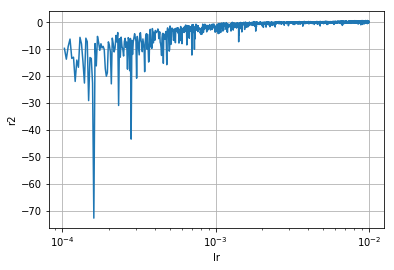

In [22]:
plt.plot(lr, r2);
plt.xlabel('lr')
plt.ylabel('r2')
plt.xscale('log')
plt.grid(True)
# plt.yscale('log')

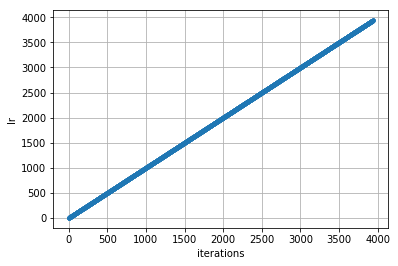

In [23]:
plt.plot(tr_iters, marker='.');
plt.xlabel('iterations')
plt.ylabel('lr')
plt.grid(True)